## Clause Risk Categorization

Putting each of the TCLP clauses into risk categories using an LLM 

In [1]:
import pandas as pd
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../")))
import utils
import json

In [2]:
risk_taxonomy = pd.read_excel('../data/risk_taxonomy.xlsx')

In [3]:
clause_folder = "../data/cleaned_content"
clause_html = '../data/clause_boxes'
model_path = "../models/CC_BERT/CC_model_detect"

In [4]:
tokenizer, d_model, c_model, names, docs, final_df = utils.getting_started(model_path, clause_folder, clause_html)

/Users/georgia/Documents/coding/climate_risk_id/tclp/utils.py:557: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(content, "html.parser")


In [5]:
# make a df of names and docs
df = pd.DataFrame({'name': names, 'clause': docs})

In [6]:
risk_taxonomy

,Label,Description
0,Physical-flooding,Clause that helps reduce exposure to flooding ...
1,Physical-wildfire,Clause that helps mitigate exposure to wildfir...
2,Physical-heat,Clause that helps reduce exposure to overheati...
3,Physical-subsidence,Clause that helps reduce exposure to ground in...
4,Physical-sea-level,Clause that helps reduce exposure to coastal e...
5,Physical-water-scarcity,Clause that helps reduce exposure to water str...
6,Physical-extreme-weather,"Clause that helps reduce exposure to storm, wi..."
7,Physical-infrastructure,Clause that helps reduce exposure to infrastru...
8,Physical-general,Clause that helps manage general exposure to p...
9,Transition-mees,Clause that helps reduce exposure to MEES-rela...


In [7]:
from openai import OpenAI

client = OpenAI(
    api_key=os.getenv("OPENROUTER_API_KEY"), 
    base_url = "https://openrouter.ai/api/v1"
)

________

### Alternate approach

In [74]:
def get_message(clause_text):     
    system_message = """You are a legal expert in climate risk and environmental compliance who understands niche risks specific to given industries. Your task is to analyze legal contract clauses and identify the climate-related risk categories they help mitigate.

You must return actual categories of risk—things that an organization or stakeholder could be exposed to or harmed by in a climate-related context—not general sustainability themes or policy goals.

Each label must represent a distinct risk exposure that could reasonably form the basis for a risk disucssed in a risk register or climate disclosure report. But be specific in the risks; don't limit yourself to the exact risk types from those reports."""

    user_message = f"""
    ### CLAUSE TO ANALYZE
    {clause_text}

    ### INSTRUCTIONS
    You are categorizing this clause according to the most relevant climate risks it could help mitigate. Don't be afraid to be specific and technical in your categorizations.

    Respond only with climate-related risk categories — not actions, technologies, or generic environmental terms.
    
    Typically three areas of risk will be sufficient but you can include up to five, if necessary. 

    Return your answer in this JSON format:
    {{
        "labels": ["Climate Risk Category 1", "Climate Risk Category 2", ...],
        "justification": [
            "Justification for Category 1",
            "Justification for Category 2",
            ...
        ]
    }}
"""
    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
    ]
    return messages


In [79]:
clause_1 = df.iloc[1]['name'] + df.iloc[1]['clause'] 

In [80]:
message = get_message(clause_1)

In [81]:
response = client.chat.completions.create(
        model='openai/gpt-4o-mini',
        messages= message,
        temperature=0
    )

In [82]:
response.choices[0].message.content

'{\n    "labels": [\n        "Regulatory Compliance Risk",\n        "Reputational Risk",\n        "Financial Liability Risk",\n        "Data Accuracy Risk"\n    ],\n    "justification": [\n        "This clause ensures that both parties are compliant with regulations regarding greenhouse gas emissions reporting, thereby mitigating the risk of penalties or legal action due to non-compliance.",\n        "By clearly defining responsibilities for emissions reporting, the clause helps both parties maintain a positive public image and stakeholder trust, reducing the risk of reputational damage associated with poor environmental practices.",\n        "Accurate measurement and reporting of emissions can influence financial performance, particularly in industries facing carbon pricing or emissions trading schemes. This clause mitigates the risk of unexpected financial liabilities arising from inaccurate emissions data.",\n        "The clause establishes a framework for accurate data collection a

In [83]:
def perform_risk_analysis(clause_text):
    message = get_message(clause_text)
    
    response = client.chat.completions.create(
        model='openai/gpt-4o-mini',
        messages=message,
        temperature=0
    )
    
    return response.choices[0].message.content

In [84]:
long_results = []

In [85]:
for i, row in df.iterrows():
    clause_text = row['name'] + row['clause']
    result = perform_risk_analysis(clause_text)
    print(f"Processing clause {i+1}/{len(df)}: {row['name']}")
    parsed = json.loads(result) if isinstance(result, str) else result
    labels = parsed.get("labels", [])
    justifications = parsed.get("justification", [])

    # Ensure list types
    if isinstance(justifications, str):
        justifications = [justifications]
    if len(justifications) != len(labels):
        # Fallback: repeat full justification for each label
        justifications = [justifications[0]] * len(labels)

    for label, justification in zip(labels, justifications):
        long_results.append({
            "name": row['name'],
            "risk_label": label,
            "justification": justification
        })

results_df = pd.DataFrame(long_results)


Processing clause 1/122: A Beginner’s Guide and Checklist for Accessing Sustainability-Linked Loans (SLLs)
Processing clause 2/122: Allocating Scope 1, 2 and 3 Emissions for Leased Assets
Processing clause 3/122: Auditing Water Usage in Supply Chains
Processing clause 4/122: Avoiding Excessive Paperwork in Dispute Resolution
Processing clause 5/122: Benchmarking of Project Greenhouse Gas Emissions
Processing clause 6/122: Board Minutes: Consideration of Climate Change Factors
Processing clause 7/122: Board Paper Implementing Net Zero for SMEs
Processing clause 8/122: CLLS Certificate of Title: Climate Change Disclosures
Processing clause 9/122: Capital Markets ESG Due Diligence Questionnaire
Processing clause 10/122: Carbon Contract Clauses for Environmental Performance, and Associated Incentives and Remedies
Processing clause 11/122: Carbon Footprint Reduction – Mutual Notification Right (Carbon Footprint Reduction Notice)
Processing clause 12/122: Circular Economy Product Design Obli

In [87]:
results_df.to_csv('../data/risk_categorization_2.csv', index=False)

_______

## Back to original approach

In [8]:
messages = "You are a helpful assistant whose job it is to identify the risk type given a provided clause. These clauses WILL NOT contain the risk themselves. Rather, they are designed to help legal users to mitigate risk. So you are meant to identify the risk categorizations that the given clause might help protect against. Feel free to pick more than one risk that you think the clause could be relevant for."

In [9]:
clause_1 = df.iloc[0]['name'] + df.iloc[0]['clause'] 

In [122]:
result = utils.classify_clause(clause_1, risk_taxonomy, messages, client)

In [123]:
print(result)

{
  "labels": ["Transition-retrofit", "Transition-standards", "Transition-disclosure"],
  "justification": "The clause provides a detailed guide and checklist for accessing Sustainability-Linked Loans (SLLs), which helps companies align their financial strategies with net zero transition goals. It includes setting sustainability performance targets (SPTs), reporting on progress, and ensuring these targets are ambitious and meaningful. This helps mitigate risks related to future retrofit obligations (Transition-retrofit) by encouraging companies to take proactive steps to improve their sustainability performance. It also addresses the need to align with voluntary standards and frameworks (Transition-standards), such as the LMA Sustainability Linked Loan Principles, which can help avoid reputational risks. Additionally, the clause emphasizes the importance of disclosure and reporting, which can help reduce exposure to legal claims related to failure to disclose known or foreseeable clima

____

## Creating database and applying this to all clauses

In [124]:
# Get the list of all possible risk labels (from your taxonomy)
risk_labels = list(risk_taxonomy['Label'].str.strip())

In [125]:
results_df = pd.DataFrame(columns=['name'] + risk_labels + ['justification'])

In [ ]:
def perform_risk_categorization(df, results_df): 
    for i, row in df.iterrows():
        clause_text = row['name'] + row['clause']
        result = utils.classify_clause(clause_text, risk_taxonomy, messages, client)
        
        print(f"Processing clause {i+1}/{len(df)}: {row['name']}")
        
        # Format the result
        formatted_row = utils.format_classification_result(row['name'], result, risk_labels)
        
        # Append to the DataFrame
        results_df = pd.concat([results_df, pd.DataFrame([formatted_row])], ignore_index=True)
    
    return results_df

In [154]:
def post_process_results(results_df):
    results_df[risk_labels] = results_df[risk_labels].astype(int)
    results_df['total_risks'] = results_df[risk_labels].sum(axis=1)
    results_df['has_risk_flag'] = results_df[risk_labels].any(axis=1).map({True: 'TRUE', False: 'FALSE'})
    results_df['combined_labels'] = results_df[risk_labels] \
    .eq(1) \
    .apply(lambda mask: ', '.join(mask.index[mask]), axis=1)
    return results_df

In [146]:
results_df.has_risk_flag.value_counts()

has_risk_flag
TRUE     103
FALSE     19
Name: count, dtype: int64

____

# Doing this again for the ones that were skipped the first time

In [166]:
false_df = results_df[results_df['has_risk_flag'] == 'FALSE']

In [167]:
zeros_list = false_df['name'].tolist()

#subset the original df to only those clauses that have no labels
df_0s = df[df['name'].isin(zeros_list)]

In [168]:
new_results = pd.DataFrame(columns=['name'] + risk_labels + ['justification'])

In [169]:
new_results = perform_risk_categorization(df_0s, new_results)

Processing clause 15/2: Climate-Related Disclosure in Loans
Processing clause 104/2: Stakeholder Company Climate Questionnaire


In [170]:
new_results = post_process_results(new_results)

In [171]:
orig = results_df.set_index('name')
updates = new_results.set_index('name')

# 2. Overwrite only those rows in `orig` where `updates` has data
orig.update(updates)

# 3. Bring `name` back as a column
results_df = orig.reset_index()

In [172]:
results_df.has_risk_flag.value_counts()

has_risk_flag
TRUE    122
Name: count, dtype: int64

In [173]:
#save the results
results_df.to_csv('../data/risk_categorization_results.csv', index=False)

_____

# Clustering Risks

This is a continuation of the alternate approach

In [107]:
df = pd.read_csv('../data/risk_categorization_2.csv')

In [108]:
unique_labels = df.risk_label.unique()

In [109]:
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("thenlper/gte-small")
embeddings = embedding_model.encode(unique_labels, show_progress_bar=True)

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [110]:
from umap.umap_ import UMAP
umap_model = UMAP(n_components=3, min_dist=0.0, metric='euclidean', random_state=42)
reduced_embeddings = umap_model.fit_transform(embeddings)

In [111]:
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size=5, metric="euclidean", cluster_selection_method="eom").fit(reduced_embeddings)
clusters = hdbscan_model.labels_

In [112]:
from bertopic import BERTopic
topic_model = BERTopic(embedding_model=embedding_model, umap_model=umap_model, hdbscan_model=hdbscan_model)
topics, probs = topic_model.fit_transform(unique_labels, embeddings)

In [113]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,16,-1_operational_emissions_ghg_employee,"[operational, emissions, ghg, employee, from, ...","[Operational Carbon Emissions Risk, Operationa..."
1,0,44,0_financial_risk_investment_market,"[financial, risk, investment, market, value, p...","[Financial Risk from Investment Uncertainty, F..."
2,1,27,1_climate_liability_related_claims,"[climate, liability, related, claims, litigati...","[Financial Risk from Climate Liability, Liabil..."
3,2,25,2_management_degradation_water_risk,"[management, degradation, water, risk, resourc...","[Waste Management Risk, Land Use and Managemen..."
4,3,22,3_reputational_non_from_compliance,"[reputational, non, from, compliance, with, pr...","[Reputational Risk from ESG Non-Compliance, Re..."
5,4,12,4_regulatory_compliance_standards_environmental,"[regulatory, compliance, standards, environmen...","[Regulatory Risk Related to Climate Standards,..."
6,5,12,5_operational_in_risk_financing,"[operational, in, risk, financing, optimizatio...","[Operational Emissions Risk, Operational Risk ..."
7,6,10,6_carbon_emission_pricing_emissions,"[carbon, emission, pricing, emissions, penalti...","[Soil Carbon Emission Risk, Financial Risk fro..."
8,7,8,7_transition_market_low_economy,"[transition, market, low, economy, to, finance...","[Transition Risk, Market Transition Risk, Mark..."
9,8,7,8_chain_supply_procurement_vulnerability,"[chain, supply, procurement, vulnerability, di...","[Supply Chain Disruption Risk, Supply Chain Em..."


In [114]:
topic_df = topic_model.get_topic_info()

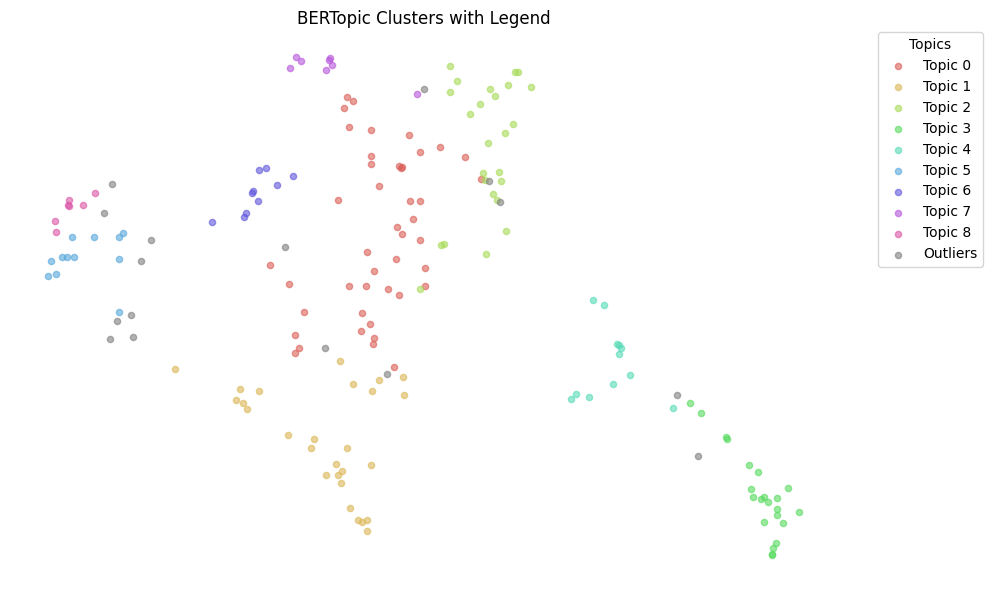

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create DataFrame
df_plot = pd.DataFrame(reduced_embeddings, columns=["x", "y", "z"])
df_plot["topic"] = topics

# Create color palette (excluding -1 if present)
unique_topics = sorted(set(topics))
if -1 in unique_topics:
    unique_topics.remove(-1)
    include_outliers = True
else:
    include_outliers = False

# Assign a color per topic
palette = sns.color_palette("hls", len(unique_topics))
topic_to_color = {topic: palette[i] for i, topic in enumerate(unique_topics)}
if include_outliers:
    topic_to_color[-1] = (0.5, 0.5, 0.5)  # grey for outliers

# Assign colors to each point
df_plot["color"] = df_plot["topic"].map(topic_to_color)

# Plot
plt.figure(figsize=(10, 6))
for topic in topic_to_color:
    subset = df_plot[df_plot["topic"] == topic]
    label = f"Topic {topic}" if topic != -1 else "Outliers"
    plt.scatter(subset["x"], subset["y"], 
                c=[topic_to_color[topic]], 
                label=label, 
                s=20, alpha=0.6)

plt.legend(title="Topics", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.axis("off")
plt.title("BERTopic Clusters with Legend")
plt.tight_layout()
plt.show()


In [116]:
df_bert = pd.DataFrame({
    "text": unique_labels,
    "topic": topics,
    "probability": probs
})


In [120]:
#rename text to risk_label in df_bert
df_bert.rename(columns={"text": "risk_label"}, inplace=True)

In [121]:
#merge this back with the original results
df = df.merge(df_bert, on="risk_label", how="left", suffixes=("", "_bert"))

In [122]:
df

,name,risk_label,justification,topic,probability
0,A Beginner’s Guide and Checklist for Accessing...,Regulatory Compliance Risk,The clause encourages borrowers to meet Sustai...,4,1.000000
1,A Beginner’s Guide and Checklist for Accessing...,Reputational Risk,By promoting sustainability-linked loans and t...,3,1.000000
2,A Beginner’s Guide and Checklist for Accessing...,Financial Performance Risk,The financial terms of the loan are directly t...,0,0.961836
3,A Beginner’s Guide and Checklist for Accessing...,Operational Risk,The requirement for regular reporting and comp...,5,1.000000
4,A Beginner’s Guide and Checklist for Accessing...,Market Access Risk,The clause supports access to finance that is ...,0,1.000000
...,...,...,...,...,...
584,"Transparent Sourcing of Greener, Fairer Renewa...",Supply Chain Emissions Risk,The clause addresses the need for suppliers to...,8,1.000000
585,"Transparent Sourcing of Greener, Fairer Renewa...",Modern Slavery and Human Rights Risk,"By prohibiting modern slavery practices, the c...",7,0.489007
586,"Transparent Sourcing of Greener, Fairer Renewa...",Environmental Compliance Risk,The requirement for environmental assessments ...,4,0.520560
587,"Transparent Sourcing of Greener, Fairer Renewa...",Carbon Budget Violation Risk,The clause sets a specific carbon budget that ...,6,1.000000
